In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare demographic part of the data

In [43]:
transactions = pd.read_csv('customer_transaction_data.csv').groupby(['date','customer_id','item_id'])[['quantity','selling_price','other_discount','coupon_discount']].sum().reset_index()
transaction_freq=transactions.groupby(['customer_id','date'])\
.agg(average_selling_price =('selling_price','mean'),average_other_discount = ('other_discount','mean'),\
     average_coupon_discount = ('coupon_discount','mean'),sum_of_quantity = ('quantity','sum')).reset_index()

transaction_customer=transactions.groupby(['customer_id'])\
.agg(sum_selling_price =('selling_price','sum'),sum_other_discount = ('other_discount','sum'),\
     sum_coupon_discount = ('coupon_discount','sum'),sum_of_quantity = ('quantity','sum')).reset_index()

freq = transaction_freq.groupby('customer_id').agg(visit_times = ('date','count'))

transaction_customer = pd.merge(transaction_customer,freq,on='customer_id',how='inner')

# Get dummies

demographic_new = pd.read_csv('customer_demographics.csv')
demographic_new.marital_status = demographic_new.marital_status.fillna('Unknown')
demographic_new.no_of_children = demographic_new.no_of_children.fillna('Unknown')
demographic_new = pd.get_dummies(demographic_new,columns=['age_range','marital_status','rented','no_of_children','family_size'])
transaction_customer_1 = pd.merge(transaction_customer,demographic_new,how='inner',on=['customer_id'])
transaction_customer_1

,customer_id,sum_selling_price,sum_other_discount,sum_coupon_discount,sum_of_quantity,visit_times,income_bracket,age_range_18-25,age_range_26-35,age_range_36-45,...,rented_1,no_of_children_1,no_of_children_2,no_of_children_3+,no_of_children_Unknown,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5+
0,1,98513.93,-17030.40,-2116.83,1227,56,4,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,6,59508.22,-6997.13,-409.62,707,34,5,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,7,107477.03,-18747.40,-785.43,57763,71,3,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,8,299482.15,-31011.15,-6605.29,1334454,134,6,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,10,50960.30,-5636.46,0.00,81165,82,5,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1577,39296.50,-7365.46,-124.67,37628,21,5,0,0,1,...,0,0,0,0,1,0,1,0,0,0
756,1578,82019.46,-14583.83,-767.62,107107,37,6,0,0,0,...,0,1,0,0,0,0,0,1,0,0
757,1579,146358.89,-26649.97,-338.39,1756,149,4,0,0,0,...,0,0,0,0,1,1,0,0,0,0
758,1580,59426.10,-6716.86,0.00,20467,100,5,0,1,0,...,0,0,0,0,1,0,1,0,0,0


# Prepare item frequency statistics

In [44]:
item = pd.read_csv('item_data.csv').drop(['brand'],axis=1)
'''
encoder = OrdinalEncoder()
item[['brand_type','category']] = encoder.fit_transform(item[['brand_type','category']])
'''


tx_item = pd.merge(transactions,item,on='item_id',how='inner')
tx_item

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,brand_type,category
0,2012-01-02,67,10537,3,32.06,0.00,0.0,Established,Grocery
1,2012-01-11,1420,10537,4,42.74,0.00,0.0,Established,Grocery
2,2012-01-19,67,10537,1,10.69,0.00,0.0,Established,Grocery
3,2012-02-17,1323,10537,2,21.37,0.00,0.0,Established,Grocery
4,2012-02-21,19,10537,2,21.37,0.00,0.0,Established,Grocery
...,...,...,...,...,...,...,...,...,...
1320382,2013-07-03,1476,48316,1,209.09,-139.63,0.0,Established,Skin & Hair Care
1320383,2013-07-03,1476,70550,1,179.17,-119.68,0.0,Established,Skin & Hair Care
1320384,2013-07-03,1476,73867,1,27.78,0.00,0.0,Established,Pharmaceutical
1320385,2013-07-03,1485,74015,1,142.12,0.00,0.0,Local,Seafood


In [45]:
pivot1 = tx_item.groupby(['customer_id','category']).agg(count=('item_id','count'))\
.pivot_table(index=['customer_id'], columns=['category'], values=['count'])
pivot1.columns=pivot1.columns.droplevel(0)
pivot1 = pivot1.fillna(0)

pivot2 = tx_item.groupby(['customer_id','brand_type']).agg(count=('item_id','count'))\
.pivot_table(index=['customer_id'], columns=['brand_type'], values=['count'])
pivot2.columns=pivot2.columns.droplevel(0)
pivot2 = pivot2.fillna(0)

# join back to df.
customer_clustering = pd.merge(transaction_customer_1,pivot1,on='customer_id',how='inner')
customer_clustering = pd.merge(customer_clustering,pivot2,on='customer_id',how='inner')
customer_clustering = customer_clustering.drop(['customer_id'],axis=1)

Text(0.5, 0, 'Number of Clusters')

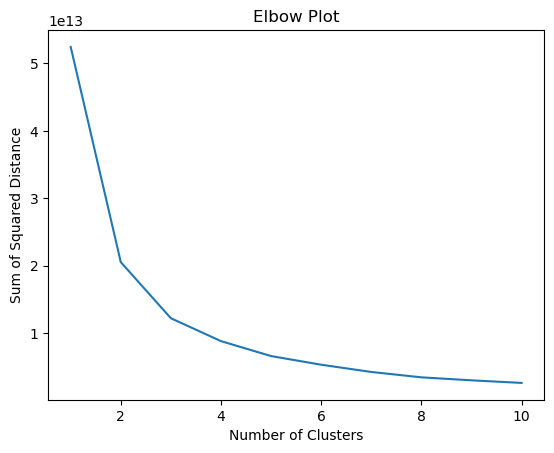

In [46]:
from sklearn.cluster import KMeans 

inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(customer_clustering)
    inertia.append(kmeans.inertia_)
inertia

plt.plot([x for x in range(1,11)],inertia)
plt.title('Elbow Plot')
plt.ylabel('Sum of Squared Distance')
plt.xlabel('Number of Clusters')

In [65]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_clustering)

customer_mean = customer_clustering.mean(axis=0)

centroiods_3 = pd.DataFrame(kmeans.cluster_centers_)

In [69]:
pd.DataFrame(kmeans.labels_).to_csv('label.csv')

# Agglomerative

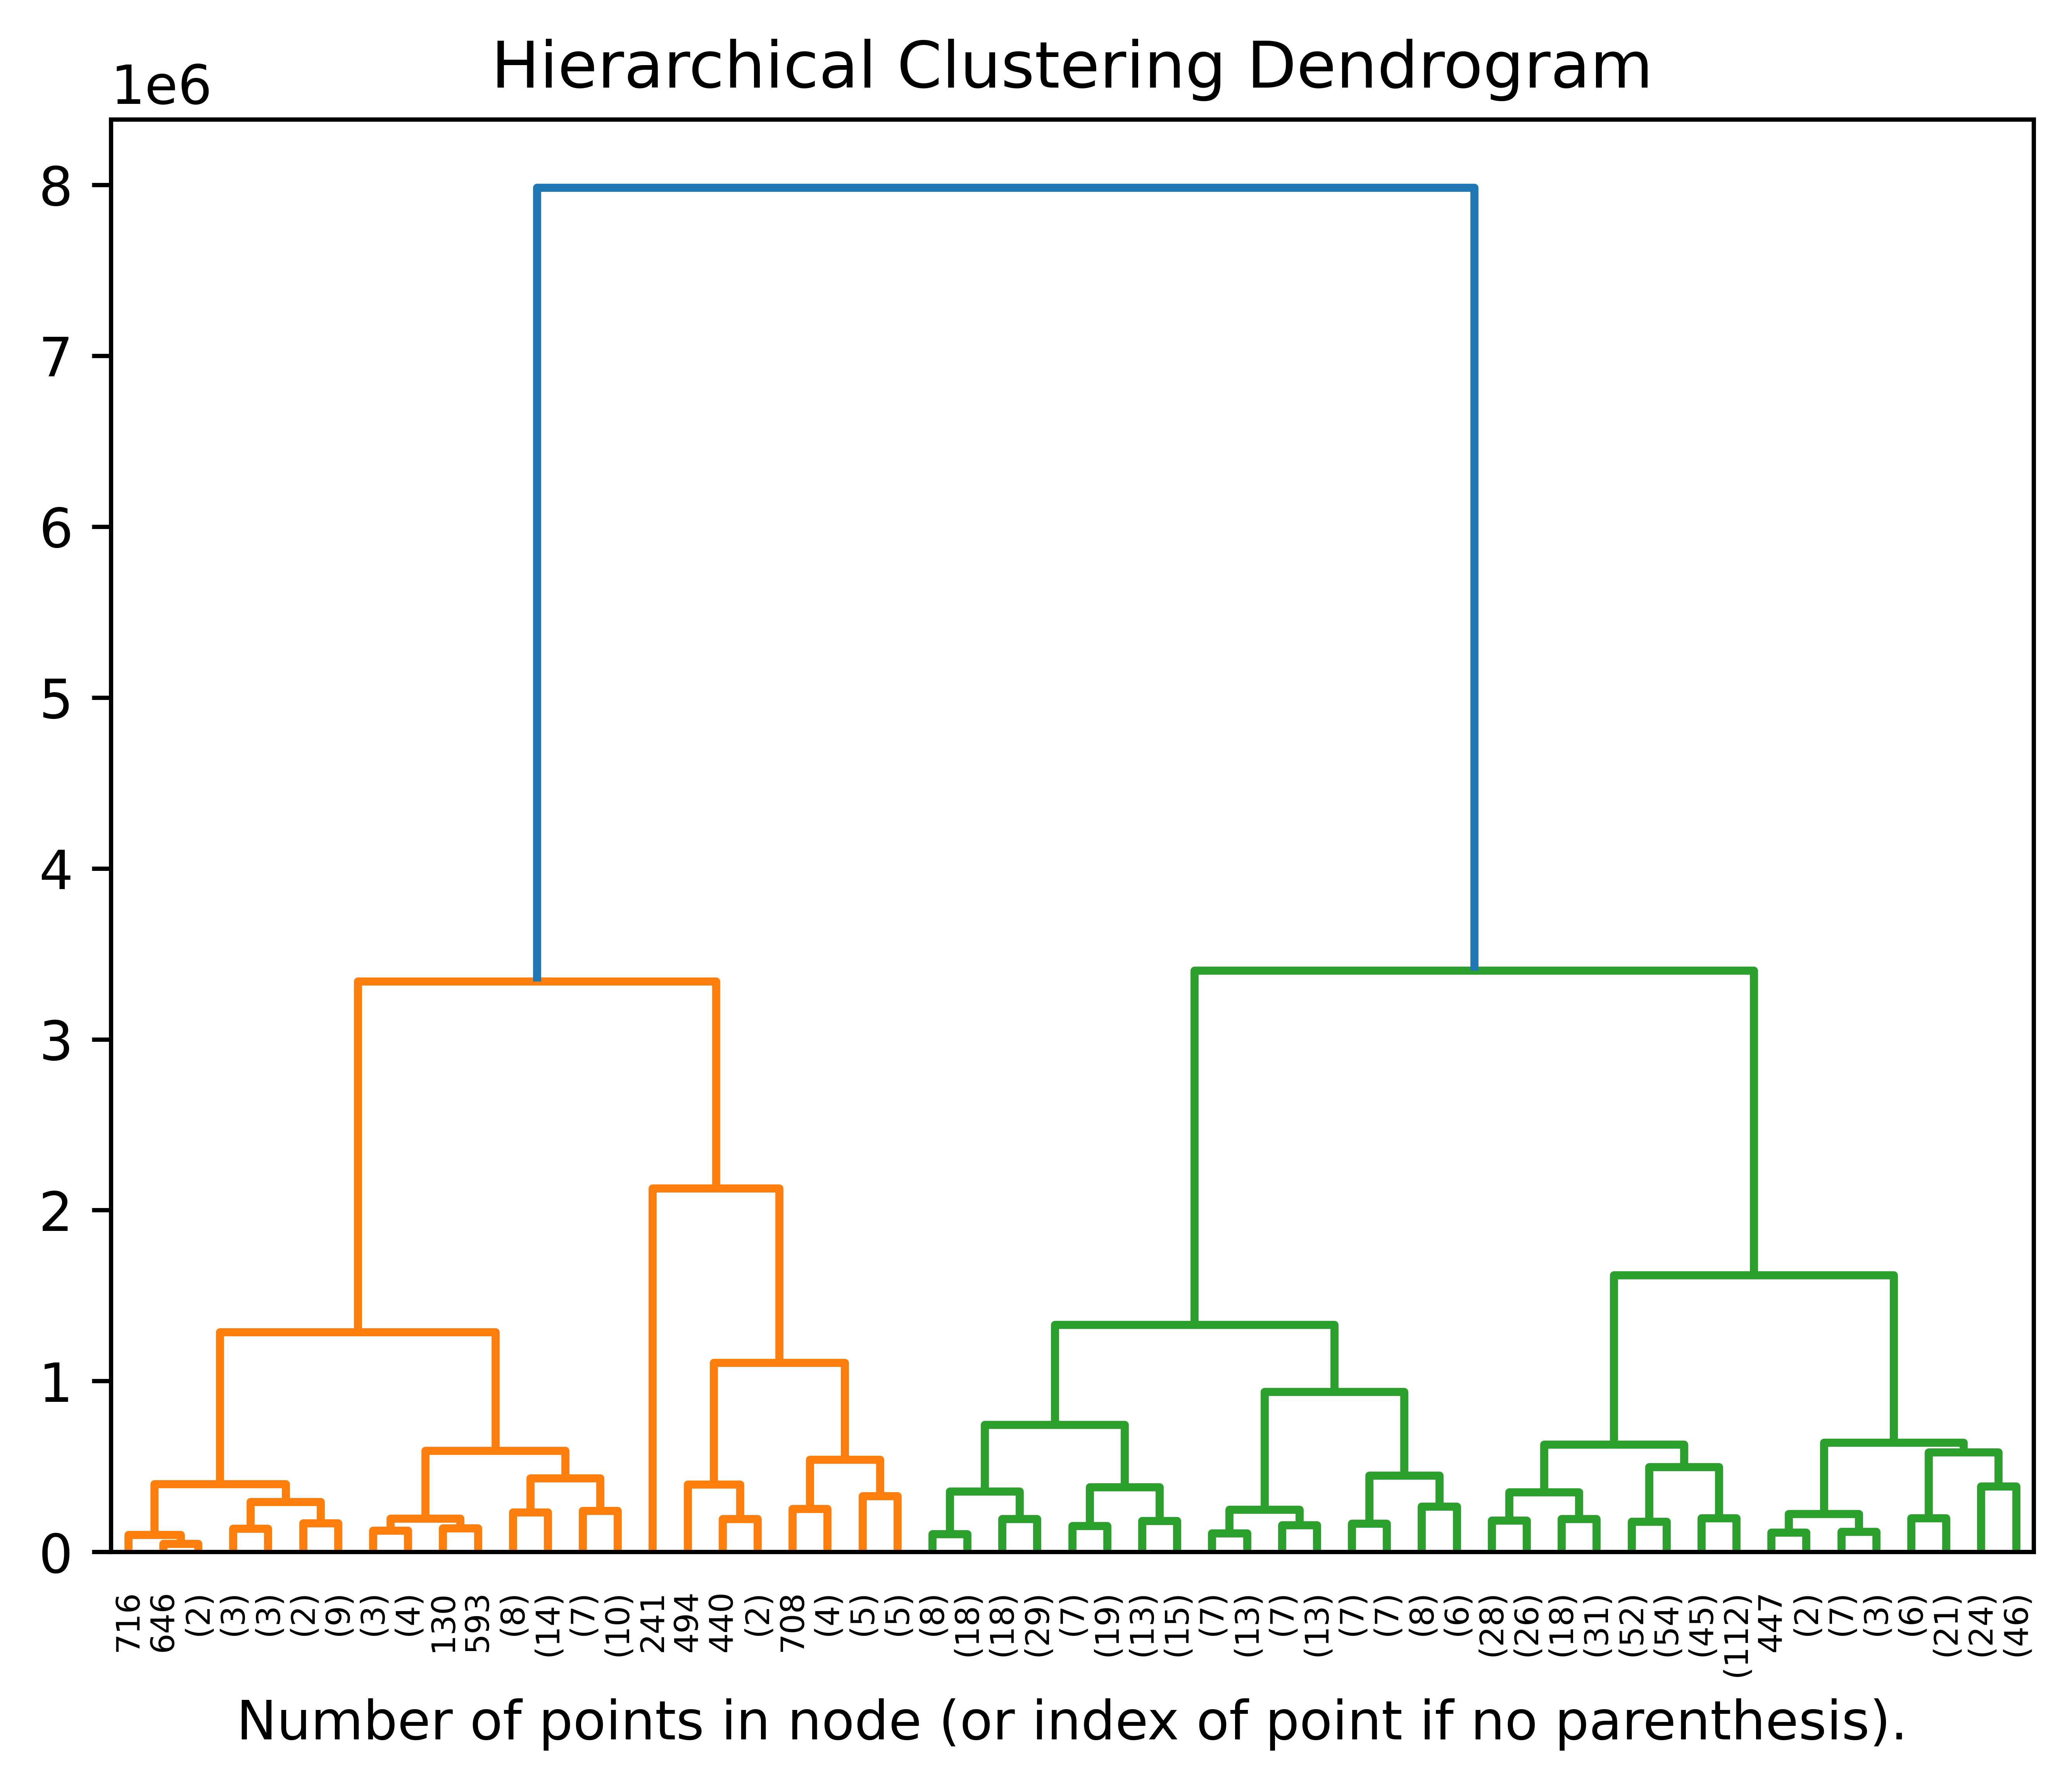

In [11]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

agg = agg.fit(customer_clustering)
plt.figure(dpi=1000)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [42]:
transactions = pd.read_csv('customer_transaction_data.csv').groupby(['date','customer_id','item_id'])[['quantity','selling_price','other_discount','coupon_discount']].sum().reset_index()
transactions

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,67,10537,3,32.06,0.00,0.00
1,2012-01-02,67,19560,2,106.86,-2.85,0.00
2,2012-01-02,67,21653,1,44.52,-12.11,0.00
3,2012-01-02,67,32083,1,8.90,0.00,0.00
4,2012-01-02,135,4642,1,44.52,-12.11,0.00
...,...,...,...,...,...,...,...
1320382,2013-07-03,1558,32271,2,47.73,-8.55,0.00
1320383,2013-07-03,1558,36961,3,106.86,-102.59,0.00
1320384,2013-07-03,1558,50180,1,23.51,-4.63,0.00
1320385,2013-07-03,1558,64114,2,71.24,-20.66,0.00
